# Airline Delay Prediction Project
- The final aim of this project is to create a model that can predict the extent of delay for any given flight.
-  This notebook and its outputs are based on all United States Domestic Flights in 2006 (7,000,000 flights)

In [55]:
import numpy as np
import pandas as pd
import sqlite3
import os
import zipfile
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

cwd = os.getcwd()
os.chdir(r"C:\Users\oskar\Documents\Projects\Portfolio Projects")
cwd

'C:\\Users\\oskar\\Documents\\Projects\\Portfolio Projects'

## Uploading Data to SQLite DataBase

- This section uploads the large airline.csv file to the SQLite Database, from where we can filter which data we would like to extract.

In [56]:
# Create Database for kaggle data
#conn = sqlite3.connect('airline_database.db')

#chunksize = 600000 
#csv_file_path = 'airline.csv.shuffle' # replace with your file path
#table_name = 'airline_data' #table name in sqlite

# Read the CSV and upload each chunk to the SQLite database
#for chunk in pd.read_csv(csv_file_path, chunksize=chunksize, encoding='ISO-8859-1'):
    #chunk.to_sql(name=table_name, con=conn, if_exists='append')

## Querying the SQLite DataBase

- "LIMIT" can be removed or added from the query line to change number of rows of data placed into dataframe. 

- In this case LIMIT is removed so all 7,000,000 records are included in the plane_df

In [102]:
# Establish a connection to the SQLite database
conn = sqlite3.connect('airline_database.db')

# Define the desired column names. 
# The below list can be removed to reveal other variables that I chose not to include in the project.
column_names = ['Origin', 'Dest', 'Distance', 'DayOfWeek', 'DayofMonth', 'Month',
                'Year', 'CRSDepTime', 'CRSElapsedTime', 'CRSArrTime',
                'UniqueCarrier', 'ArrDelay','Cancelled','Diverted', "DepDelay"]

# Constructing the SQL Query
query = "SELECT {} FROM airline_data WHERE Year = 2006;".format(','.join(column_names))

# Execute query and push into dataframe
plane_df = pd.read_sql_query(query, conn, index_col=None)

# Close the database connection
conn.close()

len(plane_df)

7141922

# Feature Engineering + Additional Data Collection

### Remove rows of data for flights that were diverted/cancelled + making separate dataframes for each for further analysis in the future.

In [58]:
div_canc = plane_df[(plane_df["Diverted"]==1)|(plane_df["Cancelled"]==1)]
div_canc.to_csv("diverted_cancelled.csv")
plane_df = plane_df.drop(plane_df[(plane_df["Cancelled"]==1)|(plane_df["Diverted"]==1)].index)
len(plane_df)

4888

### Generate Season Column
#### The seasons are defined as spring (March, April, May), summer (June, July, August), autumn (September, October, November) and winter (December, January, February).

In [59]:
spring = [3,4,5]
summer = [6,7,8]
autumn = [9,10,11]
winter = [12,1,2]

def season_func(month):
    if month in spring:
        return "Spring"
    elif month in summer:
        return "Summer"
    elif month in autumn:
        return "Autumn"
    elif month in winter:
        return "Winter"
    else: 
        return "Unknown"

plane_df["Season"] = plane_df["Month"].apply(season_func)
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Year,CRSDepTime,CRSElapsedTime,CRSArrTime,UniqueCarrier,ArrDelay,Cancelled,Diverted,DepDelay,Season
0,CVG,CMH,116.0,1,19,6,2006,1030,48.0,1118,OH,2.0,0,0,5.0,Summer
1,GNV,ATL,300.0,1,6,11,2006,1045,97.0,1222,EV,-2.0,0,0,-5.0,Autumn
2,ATL,SGF,563.0,7,30,7,2006,2035,112.0,2127,EV,136.0,0,0,153.0,Summer
3,HPN,ATL,780.0,4,21,12,2006,600,140.0,820,FL,4.0,0,0,1.0,Winter
4,PBI,BDL,1133.0,1,31,7,2006,1200,170.0,1450,DL,-4.0,0,0,0.0,Summer


### Loading + Merging Data for number of runways(including helipads + small runways) at origin airport, arrival airport and total number of airports

In [60]:
#airport + runway data sourced from https://ourairports.com/
airports = pd.read_csv("airports.csv")   #includes information about US airports
airports = airports[["id", "name", "iata_code"]]
airports.head()



,id,name,iata_code
0,6523,Total Rf Heliport,NaN
1,323361,Aero B Ranch Airport,NaN
2,6524,Lowell Field,NaN
3,6525,Epps Airpark,NaN
4,506791,Katmai Lodge Airport,NaN


In [61]:
runways = pd.read_csv("runways.csv") #includes information about runways.
runways = runways[["airport_ref","id",]]
no_runways = pd.DataFrame(runways["airport_ref"].value_counts().reset_index())
no_runways.columns = ["id", "no_runways"]
no_runways.head()

,id,no_runways
0,3754,11
1,300162,10
2,18256,9
3,8413,8
4,20654,8


### Merging the above 2 csv files to create a dataframe with airport + runway information.

In [62]:
merged_df = pd.merge(airports, no_runways, how="inner", on="id")
merged_df = merged_df.dropna(subset=["iata_code"], axis=0)
merged_df = merged_df.set_index("iata_code")

merged_df.head()

,id,name,no_runways
iata_code,,,
UTK,4650,Utirik Airport,1
OCA,6924,Ocean Reef Club Airport,1
PQS,7063,Pilot Station Airport,1
CSE,7139,Crested Butte Airpark,1
JCY,7545,LBJ Ranch Airport,1


In [63]:
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Year,CRSDepTime,CRSElapsedTime,CRSArrTime,UniqueCarrier,ArrDelay,Cancelled,Diverted,DepDelay,Season
0,CVG,CMH,116.0,1,19,6,2006,1030,48.0,1118,OH,2.0,0,0,5.0,Summer
1,GNV,ATL,300.0,1,6,11,2006,1045,97.0,1222,EV,-2.0,0,0,-5.0,Autumn
2,ATL,SGF,563.0,7,30,7,2006,2035,112.0,2127,EV,136.0,0,0,153.0,Summer
3,HPN,ATL,780.0,4,21,12,2006,600,140.0,820,FL,4.0,0,0,1.0,Winter
4,PBI,BDL,1133.0,1,31,7,2006,1200,170.0,1450,DL,-4.0,0,0,0.0,Summer


### Mapping this new airport + runway information into the original dataframe.

In [64]:
plane_df['origin_runways'] = plane_df['Origin'].map(merged_df['no_runways'])
plane_df['destination_runways'] = plane_df['Dest'].map(merged_df['no_runways'])

#there was info missing for 1 airport, so manually filled it in.
plane_df['origin_runways'] = plane_df['origin_runways'].fillna(1)
plane_df['destination_runways'] = plane_df['destination_runways'].fillna(1)
plane_df["total_runways"] = plane_df["origin_runways"] + plane_df["destination_runways"]


### Converting Departure time to Minutes after midnight

In [65]:
# Convert CRSDepTime to a string and add leading zeros
plane_df['CRSDepTime'] = plane_df['CRSDepTime'].apply(lambda x: str(int(x)).zfill(4))

plane_df.head()
# Convert CRSDepTime to a datetime.time object
plane_df['CRSDepTime'] = pd.to_datetime(plane_df['CRSDepTime'], format='%H%M').dt.time

plane_df['CRSDepTimeMins_after_0000'] = plane_df['CRSDepTime'].apply(lambda x: x.hour*60 + x.minute)

### Converting Departure Time to Departure Time Frames
- Did the flight leave in the morning, afternoon, evening or night?

In [66]:
morning_start = datetime.time(6, 0, 0)
morning_end = datetime.time(11, 59, 59)

afternoon_start = datetime.time(12, 0, 0)
afternoon_end = datetime.time(17, 59, 59)

evening_start = datetime.time(18, 0, 0)
evening_end = datetime.time(23, 59, 59)

night_start = datetime.time(0, 0, 0)
night_end = datetime.time(5, 59, 59)

def time_frame(time):
    if morning_start <= time<= morning_end:
        return "Morning"
    elif afternoon_start <= time <= afternoon_end:
        return "Afternoon"
    elif evening_start <= time <= evening_end:
        return "Evening"
    elif night_start <= time <= night_end:
        return "Night"
    else: 
        return "Unknown"

plane_df["CRSDepTimeFrame"] = plane_df["CRSDepTime"].apply(time_frame)

In [67]:
plane_df['origin_runways'] = plane_df['Origin'].map(merged_df['no_runways'])
plane_df['destination_runways'] = plane_df['Dest'].map(merged_df['no_runways'])


#there was info missing for 1 airport, so manually filling it in. Airport IATA code was PFN
plane_df['origin_runways'] = plane_df['origin_runways'].fillna(1)
plane_df['destination_runways'] = plane_df['destination_runways'].fillna(1)
plane_df["total_runways"] = plane_df["origin_runways"] + plane_df["destination_runways"]


In [68]:
#Primary Airports are Commercial Service Airports that have more than 10,000 passenger boardings each year.

#I want to keep airports that are in the top 100 for total yearly outbound flights
# Coincidentally, the top 100 are the airports that have 10,000 flights minimum (2006)

top100_airports = plane_df["Origin"].value_counts()[:100].index.tolist()

plane_df = plane_df[plane_df['Origin'].isin(top100_airports)]
plane_df = plane_df.reset_index(drop=True)

## Preparing for a Classification Problem (converting numeric target variable into a categorical variable)

In [69]:
def classify_delay(delay):
    if delay <= 0:
        return 'On-time'
    elif delay <= 15:
        return 'Slightly delayed'
    elif delay <= 60:
        return 'Moderately delayed'
    else:
        return 'Excessively delayed'

plane_df["ArrDelayClass"] = plane_df["ArrDelay"].apply(classify_delay)

In [70]:
plane_df.head(10)

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Year,CRSDepTime,CRSElapsedTime,CRSArrTime,UniqueCarrier,ArrDelay,Cancelled,Diverted,DepDelay,Season,origin_runways,destination_runways,total_runways,CRSDepTimeMins_after_0000,CRSDepTimeFrame,ArrDelayClass
0,CVG,CMH,116.0,1,19,6,2006,10:30:00,48.0,1118,OH,2.0,0,0,5.0,Summer,4.0,2.0,6.0,630,Morning,Slightly delayed
1,ATL,SGF,563.0,7,30,7,2006,20:35:00,112.0,2127,EV,136.0,0,0,153.0,Summer,5.0,2.0,7.0,1235,Evening,Excessively delayed
2,PBI,BDL,1133.0,1,31,7,2006,12:00:00,170.0,1450,DL,-4.0,0,0,0.0,Summer,3.0,3.0,6.0,720,Afternoon,On-time
3,PIT,PHL,267.0,3,27,12,2006,16:50:00,70.0,1800,US,-11.0,0,0,-4.0,Winter,4.0,4.0,8.0,1010,Afternoon,On-time
4,ORD,ANC,2846.0,7,23,7,2006,19:20:00,399.0,2259,AS,-2.0,0,0,8.0,Summer,11.0,3.0,14.0,1160,Evening,On-time
5,LBB,DFW,282.0,1,20,3,2006,14:46:00,62.0,1548,MQ,86.0,0,0,50.0,Spring,3.0,7.0,10.0,886,Afternoon,Excessively delayed
6,MSP,SAN,1532.0,3,25,1,2006,17:20:00,236.0,1916,NW,-4.0,0,0,-1.0,Winter,4.0,1.0,5.0,1040,Afternoon,On-time
7,PHX,PSP,261.0,5,20,10,2006,10:06:00,72.0,1118,YV,22.0,0,0,19.0,Autumn,3.0,2.0,5.0,606,Morning,Moderately delayed
8,ATL,AEX,500.0,3,22,11,2006,20:48:00,100.0,2128,EV,-8.0,0,0,-5.0,Autumn,5.0,2.0,7.0,1248,Evening,On-time
9,GRR,DTW,120.0,3,29,11,2006,12:00:00,59.0,1259,NW,11.0,0,0,-2.0,Autumn,3.0,6.0,9.0,720,Afternoon,Slightly delayed


## Creating Additional Columns to measure airspace congestion (Domestic + By Airport)
- American Airspace Congestion("USair_congestion"): Simply how many domestics flights occurred within US airspace on a given day.

In [71]:
plane_df["Date"] = pd.to_datetime('2006-' + plane_df["Month"].astype(str) + '-' + plane_df["DayofMonth"].astype(str), format='%Y-%m-%d')
daily_flights = plane_df.groupby("Date").size()
plane_df["USair_congestion"] = plane_df['Date'].map(daily_flights) #Total number of flights across the US on a given day.
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Year,CRSDepTime,CRSElapsedTime,CRSArrTime,UniqueCarrier,ArrDelay,Cancelled,Diverted,DepDelay,Season,origin_runways,destination_runways,total_runways,CRSDepTimeMins_after_0000,CRSDepTimeFrame,ArrDelayClass,Date,USair_congestion
0,CVG,CMH,116.0,1,19,6,2006,10:30:00,48.0,1118,OH,2.0,0,0,5.0,Summer,4.0,2.0,6.0,630,Morning,Slightly delayed,2006-06-19,18
1,ATL,SGF,563.0,7,30,7,2006,20:35:00,112.0,2127,EV,136.0,0,0,153.0,Summer,5.0,2.0,7.0,1235,Evening,Excessively delayed,2006-07-30,17
2,PBI,BDL,1133.0,1,31,7,2006,12:00:00,170.0,1450,DL,-4.0,0,0,0.0,Summer,3.0,3.0,6.0,720,Afternoon,On-time,2006-07-31,12
3,PIT,PHL,267.0,3,27,12,2006,16:50:00,70.0,1800,US,-11.0,0,0,-4.0,Winter,4.0,4.0,8.0,1010,Afternoon,On-time,2006-12-27,19
4,ORD,ANC,2846.0,7,23,7,2006,19:20:00,399.0,2259,AS,-2.0,0,0,8.0,Summer,11.0,3.0,14.0,1160,Evening,On-time,2006-07-23,12


- The next feature to create is airport airspace congestion. On a given day, how many flights did an airport receive/deliver? A column will be created for both origin and destination airport.

In [72]:
daily_takeoffs_by_airport = plane_df.groupby(["Date", "Origin"]).size() #how many flights took off from each airport per day.
daily_landings_by_airport = plane_df.groupby(["Date", "Dest"]).size() #how many flights landed at each airport per day.

#renaming columns for clarity + reset index

daily_takeoffs_by_airport = daily_takeoffs_by_airport.reset_index().rename(columns={'Origin': 'Airport', 0: 'Count'})
daily_landings_by_airport = daily_landings_by_airport.reset_index().rename(columns={'Dest': 'Airport', 0: 'Count'})

daily_takeoffs_by_airport.head(7), daily_landings_by_airport.head(7)

(        Date Airport  Count
 0 2006-01-01     BHM      1
 1 2006-01-01     CLE      1
 2 2006-01-01     COS      1
 3 2006-01-01     IAD      1
 4 2006-01-01     IAH      1
 5 2006-01-01     LGA      1
 6 2006-01-01     MEM      1,
         Date Airport  Count
 0 2006-01-01     DCA      1
 1 2006-01-01     DEN      1
 2 2006-01-01     DFW      2
 3 2006-01-01     FLL      1
 4 2006-01-01     IAD      1
 5 2006-01-01     LAX      1
 6 2006-01-01     MSY      1)

In [73]:
total_flights_by_airport = pd.concat([daily_takeoffs_by_airport, daily_landings_by_airport])

total_flights_by_airport= total_flights_by_airport.groupby(["Date", "Airport"])["Count"].sum() 

total_flights_by_airport.head(10)

Date        Airport
2006-01-01  BHM        1
            CLE        1
            COS        1
            DCA        1
            DEN        1
            DFW        2
            FLL        1
            IAD        2
            IAH        1
            LAX        1
Name: Count, dtype: int64

In [74]:
total_flights_by_airport = total_flights_by_airport.reset_index()
total_flights_by_airport.head(10)

,Date,Airport,Count
0,2006-01-01,BHM,1
1,2006-01-01,CLE,1
2,2006-01-01,COS,1
3,2006-01-01,DCA,1
4,2006-01-01,DEN,1
5,2006-01-01,DFW,2
6,2006-01-01,FLL,1
7,2006-01-01,IAD,2
8,2006-01-01,IAH,1
9,2006-01-01,LAX,1


#### Mapping daily congestion for Origin

In [75]:
#takeoffs
plane_df = plane_df.merge(total_flights_by_airport, left_on=['Date', 'Origin'], right_on=['Date', 'Airport'], how='left')
plane_df.rename(columns={'Count': 'total_flights_origin'}, inplace=True)
plane_df.drop(columns='Airport', inplace=True)  # drop unneeded col

#landings
plane_df = plane_df.merge(total_flights_by_airport, left_on=['Date', 'Dest'], right_on=['Date', 'Airport'], how='left')
plane_df.rename(columns={'Count': 'total_flights_destination'}, inplace=True)
plane_df.drop(columns='Airport', inplace=True)  # drop unneeded col


In [76]:
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Year,CRSDepTime,CRSElapsedTime,CRSArrTime,UniqueCarrier,ArrDelay,Cancelled,Diverted,DepDelay,Season,origin_runways,destination_runways,total_runways,CRSDepTimeMins_after_0000,CRSDepTimeFrame,ArrDelayClass,Date,USair_congestion,total_flights_origin,total_flights_destination
0,CVG,CMH,116.0,1,19,6,2006,10:30:00,48.0,1118,OH,2.0,0,0,5.0,Summer,4.0,2.0,6.0,630,Morning,Slightly delayed,2006-06-19,18,2,2
1,ATL,SGF,563.0,7,30,7,2006,20:35:00,112.0,2127,EV,136.0,0,0,153.0,Summer,5.0,2.0,7.0,1235,Evening,Excessively delayed,2006-07-30,17,2,1
2,PBI,BDL,1133.0,1,31,7,2006,12:00:00,170.0,1450,DL,-4.0,0,0,0.0,Summer,3.0,3.0,6.0,720,Afternoon,On-time,2006-07-31,12,2,1
3,PIT,PHL,267.0,3,27,12,2006,16:50:00,70.0,1800,US,-11.0,0,0,-4.0,Winter,4.0,4.0,8.0,1010,Afternoon,On-time,2006-12-27,19,1,1
4,ORD,ANC,2846.0,7,23,7,2006,19:20:00,399.0,2259,AS,-2.0,0,0,8.0,Summer,11.0,3.0,14.0,1160,Evening,On-time,2006-07-23,12,1,2


- We now have a dataframe with our (relevant) original data + new features extracted from our original data + new data regarding airports and number of runways from a separate data source

# Data Cleaning

In [77]:
plane_df = plane_df[['Origin', 'Dest', 'Distance', 'DayOfWeek', 'DayofMonth', 'Month',
       'Season', 'CRSDepTime','CRSDepTimeMins_after_0000', 'CRSDepTimeFrame', 'CRSElapsedTime', 'CRSArrTime', 'UniqueCarrier',
       'origin_runways', 'destination_runways', 'total_runways','USair_congestion','total_flights_origin','total_flights_destination', 'DepDelay', 'ArrDelay', 'ArrDelayClass']]
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepTime,CRSDepTimeMins_after_0000,CRSDepTimeFrame,CRSElapsedTime,CRSArrTime,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,DepDelay,ArrDelay,ArrDelayClass
0,CVG,CMH,116.0,1,19,6,Summer,10:30:00,630,Morning,48.0,1118,OH,4.0,2.0,6.0,18,2,2,5.0,2.0,Slightly delayed
1,ATL,SGF,563.0,7,30,7,Summer,20:35:00,1235,Evening,112.0,2127,EV,5.0,2.0,7.0,17,2,1,153.0,136.0,Excessively delayed
2,PBI,BDL,1133.0,1,31,7,Summer,12:00:00,720,Afternoon,170.0,1450,DL,3.0,3.0,6.0,12,2,1,0.0,-4.0,On-time
3,PIT,PHL,267.0,3,27,12,Winter,16:50:00,1010,Afternoon,70.0,1800,US,4.0,4.0,8.0,19,1,1,-4.0,-11.0,On-time
4,ORD,ANC,2846.0,7,23,7,Summer,19:20:00,1160,Evening,399.0,2259,AS,11.0,3.0,14.0,12,1,2,8.0,-2.0,On-time


In [78]:
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepTime,CRSDepTimeMins_after_0000,CRSDepTimeFrame,CRSElapsedTime,CRSArrTime,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,DepDelay,ArrDelay,ArrDelayClass
0,CVG,CMH,116.0,1,19,6,Summer,10:30:00,630,Morning,48.0,1118,OH,4.0,2.0,6.0,18,2,2,5.0,2.0,Slightly delayed
1,ATL,SGF,563.0,7,30,7,Summer,20:35:00,1235,Evening,112.0,2127,EV,5.0,2.0,7.0,17,2,1,153.0,136.0,Excessively delayed
2,PBI,BDL,1133.0,1,31,7,Summer,12:00:00,720,Afternoon,170.0,1450,DL,3.0,3.0,6.0,12,2,1,0.0,-4.0,On-time
3,PIT,PHL,267.0,3,27,12,Winter,16:50:00,1010,Afternoon,70.0,1800,US,4.0,4.0,8.0,19,1,1,-4.0,-11.0,On-time
4,ORD,ANC,2846.0,7,23,7,Summer,19:20:00,1160,Evening,399.0,2259,AS,11.0,3.0,14.0,12,1,2,8.0,-2.0,On-time


In [79]:
#Organising Data Types
col_int = ["origin_runways","destination_runways","total_runways"]

for col in col_int:
    plane_df[col] = plane_df[col].astype(int)

col_cat = ["DayOfWeek", "DayofMonth","Month","Season", "UniqueCarrier", "Origin", "Dest", "ArrDelayClass"]
for col in col_cat:
    plane_df[col] = plane_df[col].astype("category")

plane_df.dtypes

Origin                       category
Dest                         category
Distance                      float64
DayOfWeek                    category
DayofMonth                   category
Month                        category
Season                       category
CRSDepTime                     object
CRSDepTimeMins_after_0000       int64
CRSDepTimeFrame                object
CRSElapsedTime                float64
CRSArrTime                      int64
UniqueCarrier                category
origin_runways                  int32
destination_runways             int32
total_runways                   int32
USair_congestion                int64
total_flights_origin            int64
total_flights_destination       int64
DepDelay                      float64
ArrDelay                      float64
ArrDelayClass                category
dtype: object

### Distribution of Arrival Delays

<Figure size 640x480 with 0 Axes>

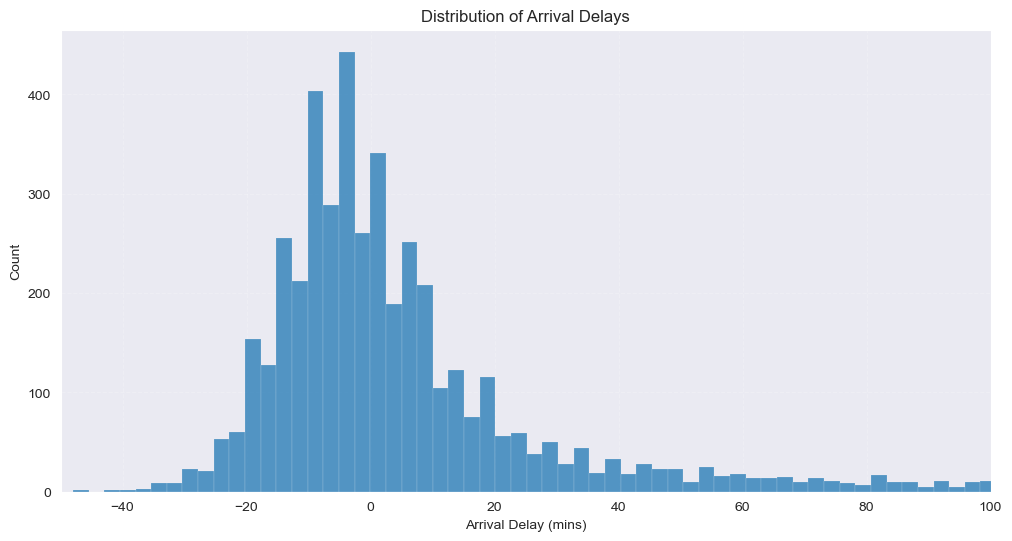

In [80]:
plt.clf()

fig, ax = plt.subplots(figsize=(12, 6))

plot = sns.histplot(plane_df["ArrDelay"],bins="auto", linewidth=0.1)
plot.set(xlim=(-50, 100))
plot.set(title="Distribution of Arrival Delays", xlabel="Arrival Delay (mins)", ylabel="Count")
plt.grid(True, linestyle="--", alpha=0.2)
plt.show()

- Normally Distributed, with some right skew. Planes can be delayed by many hours, but it is impossible for a flight to arrive multiple hours earlier.

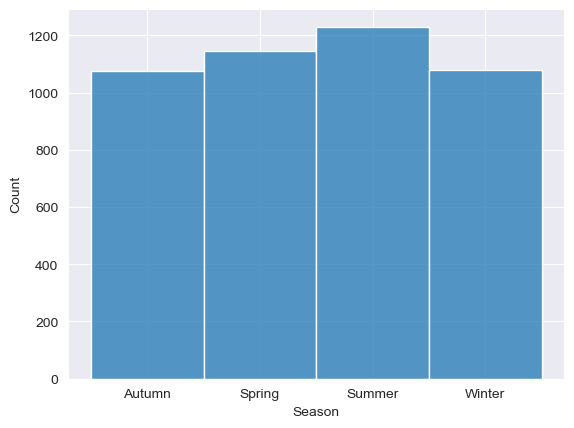

In [81]:
plt.clf()
sns.histplot(plane_df["Season"])
plt.show()

- Summer is the most popular flying season, whereas Winter is the least popular (Northern Hemisphere): Fluctuations across the year are seasonal, not drastically different at different times of year.

## Which Origin airports saw the longest arrival delays?

<Figure size 640x480 with 0 Axes>

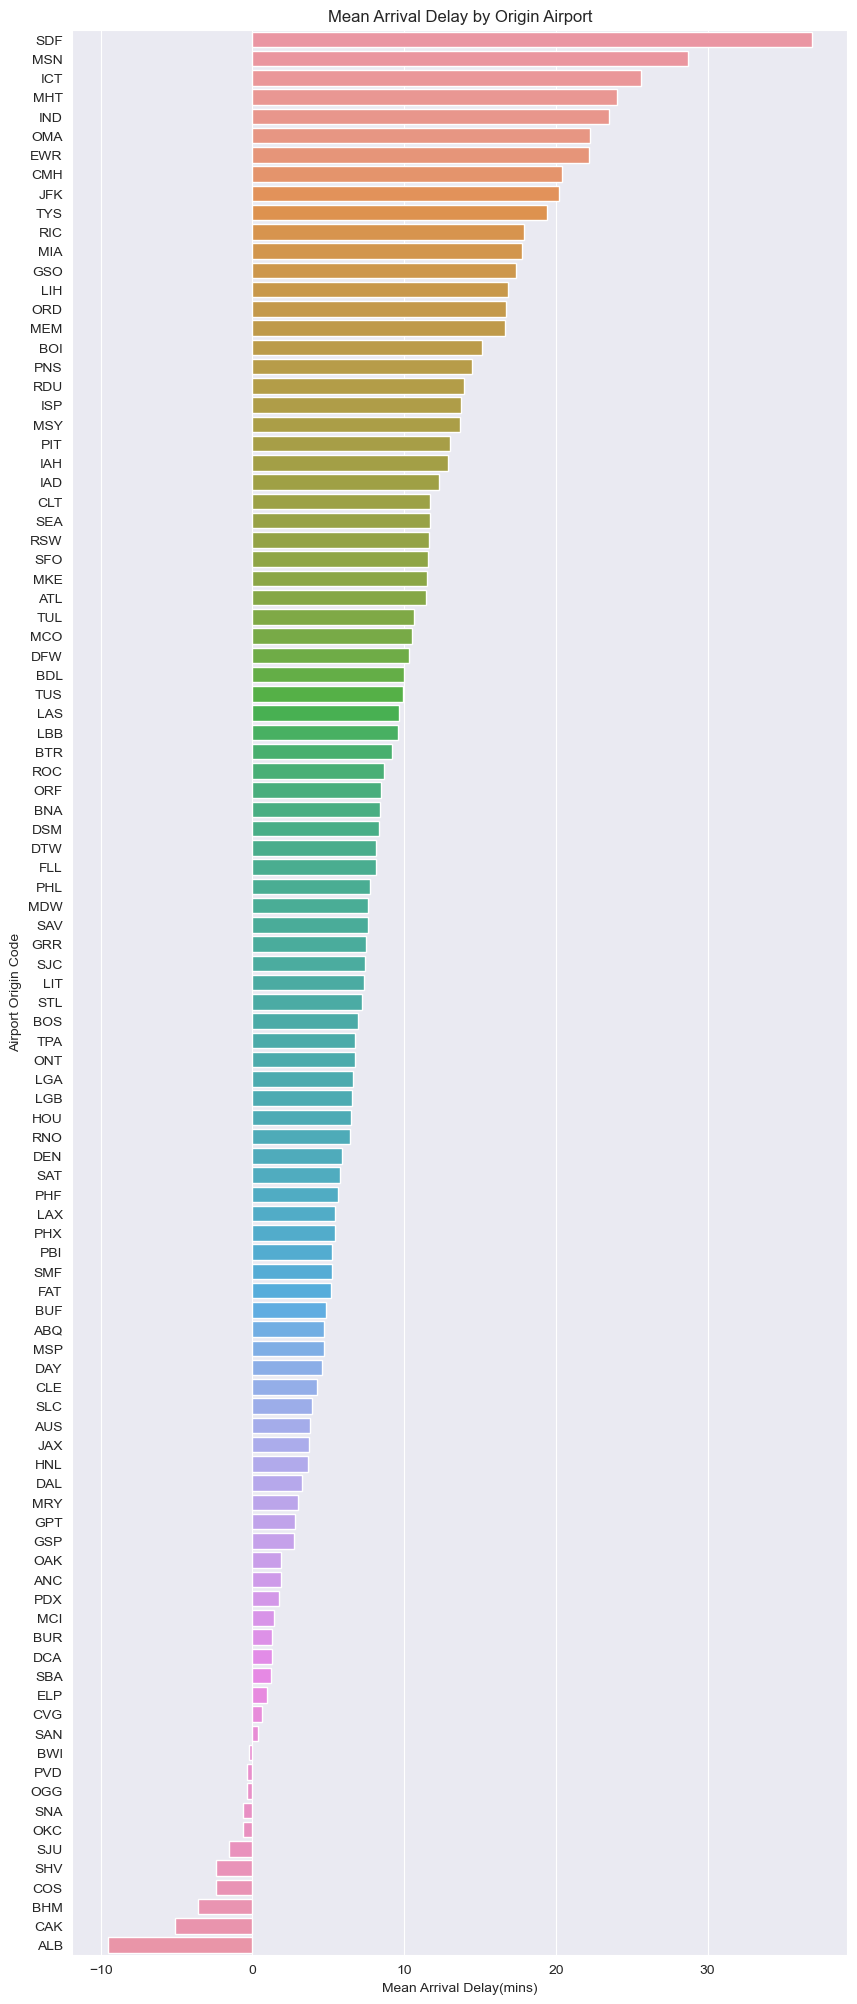

In [82]:
mean_origin_delay = plane_df.groupby("Origin")["ArrDelay"].agg(np.mean).sort_values(ascending=False)

plt.clf()
plt.figure(figsize=(10,25)) # Adjust this to change the size of your plot
sns.barplot(x=mean_origin_delay.values, y=mean_origin_delay.index, order=mean_origin_delay.index)
plt.title('Mean Arrival Delay by Origin Airport')
plt.xlabel('Mean Arrival Delay(mins)')
plt.ylabel('Airport Origin Code')
plt.show()


- Here we can see how average arrival delay varied by origin airport.
- Flights arriving from Chicago O'Hare International Airport, Newark Liberty International Airport and John F. Kennedy International Airport had the longest arrival delays.

## Which Destination airports saw the longest arrival delays?

<Figure size 640x480 with 0 Axes>

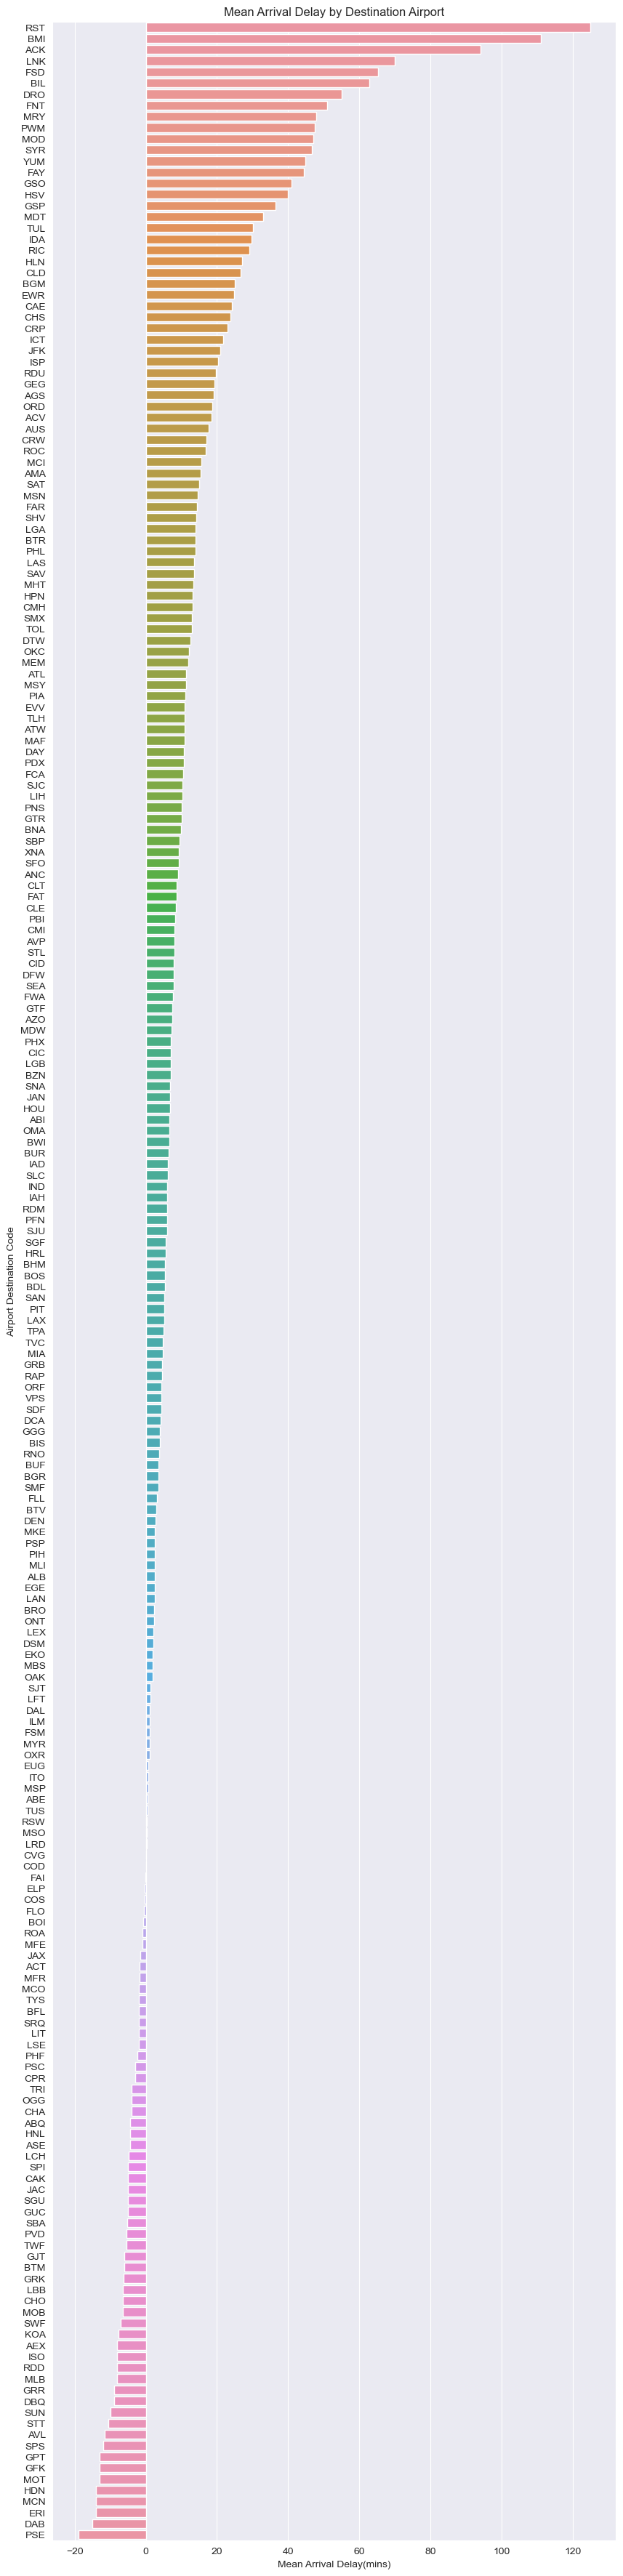

In [83]:
mean_dest_delay = plane_df.groupby("Dest")["ArrDelay"].agg(np.mean).sort_values(ascending = False)

plt.clf()
plt.figure(figsize=(10,45)) # Adjust this to change the size of your plot
sns.barplot(x=mean_dest_delay.values, y=mean_dest_delay.index, order=mean_dest_delay.index)
plt.title('Mean Arrival Delay by Destination Airport')
plt.xlabel('Mean Arrival Delay(mins)')
plt.ylabel('Airport Destination Code')
plt.show()


- Here we can see how average arrival delay varied by destination airport.
- Nantucket Memorial Airport had the longest mean arrival delay for a destination airport at ~37.5 minutes.
- Followed by Sawyer International Airport (~29 minutes) and Middle Georgia Regional Airport (25 minutes)

## Does Flight Distance correlate with arrival delay?

<Figure size 640x480 with 0 Axes>

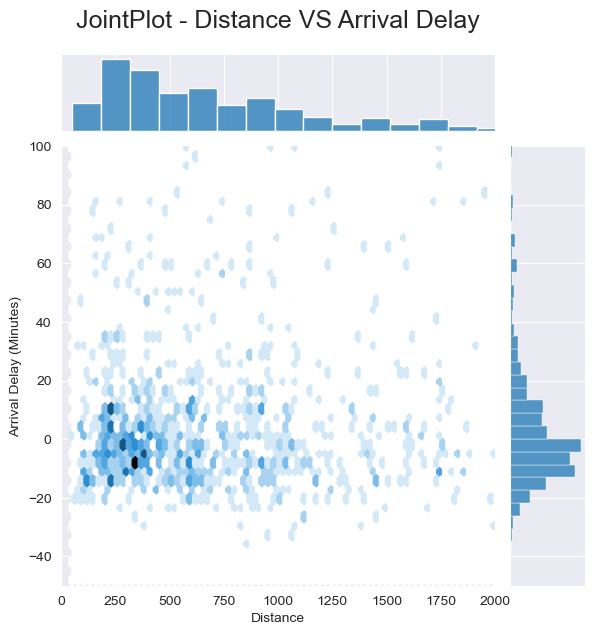

In [84]:
plt.clf()
sns.jointplot(x='Distance', y='ArrDelay', data=plane_df.sample(1000), kind='hex', gridsize=120)
plt.xlim(0,2000)
plt.ylim(-50,100)
plt.ylabel("Arrival Delay (Minutes)")
plt.title("JointPlot - Distance VS Arrival Delay", y=1.25, fontsize=18)
plt.show()


- No clear correlation between Distance and Arrival Delay. However a signigicant proportion of all flights were between 0-10 mins delayed and most flights were over distances of less than 1000 miles.

## Does Day of Week Correlate with Arrival Delay?

<Figure size 640x480 with 0 Axes>

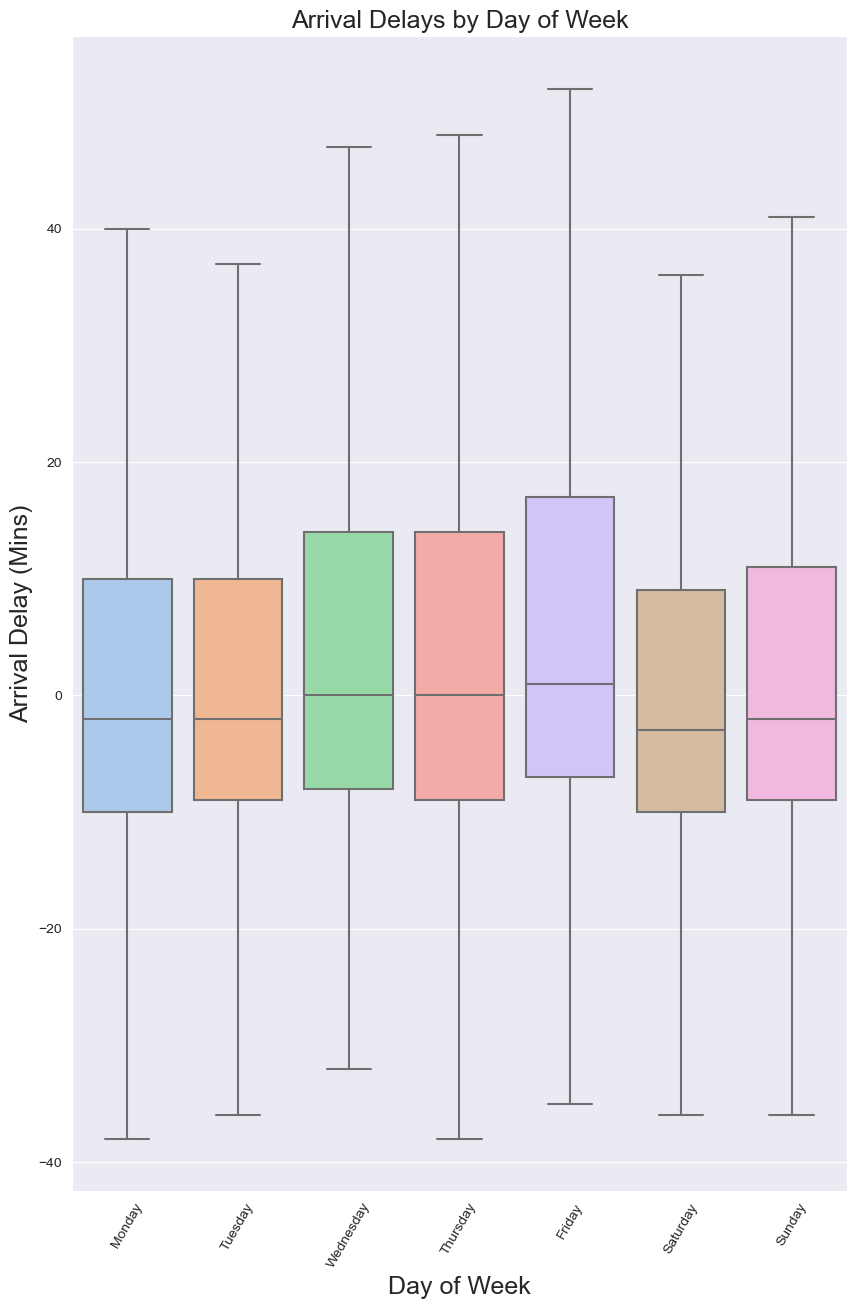

DayOfWeek
1     7.885057
2     6.793103
3    11.066773
4    10.430657
5    13.468468
6     3.800699
7     7.461912
Name: ArrDelay, dtype: float64


In [85]:
plt.clf()
sns.set_style("darkgrid")
plt.figure(figsize=(10,15)) # Adjust this depending on your dataset size
sns.boxplot(y='ArrDelay', x='DayOfWeek', data=plane_df, showfliers = False, palette="pastel")
plt.title('Arrival Delays by Day of Week', fontsize=18)
plt.xlabel('Day of Week', fontsize=18)
plt.ylabel('Arrival Delay (Mins)',fontsize=18)
labels = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
plt.xticks(range(len(labels)), labels, rotation=60)

plt.show()

print(plane_df.groupby("DayOfWeek").mean()["ArrDelay"])

- Saturday has the lowest average arrival delay, whilst Fridays has the largest delays on average across 2006.

## Does Month Correlate with Arrival Delay?

<Figure size 640x480 with 0 Axes>

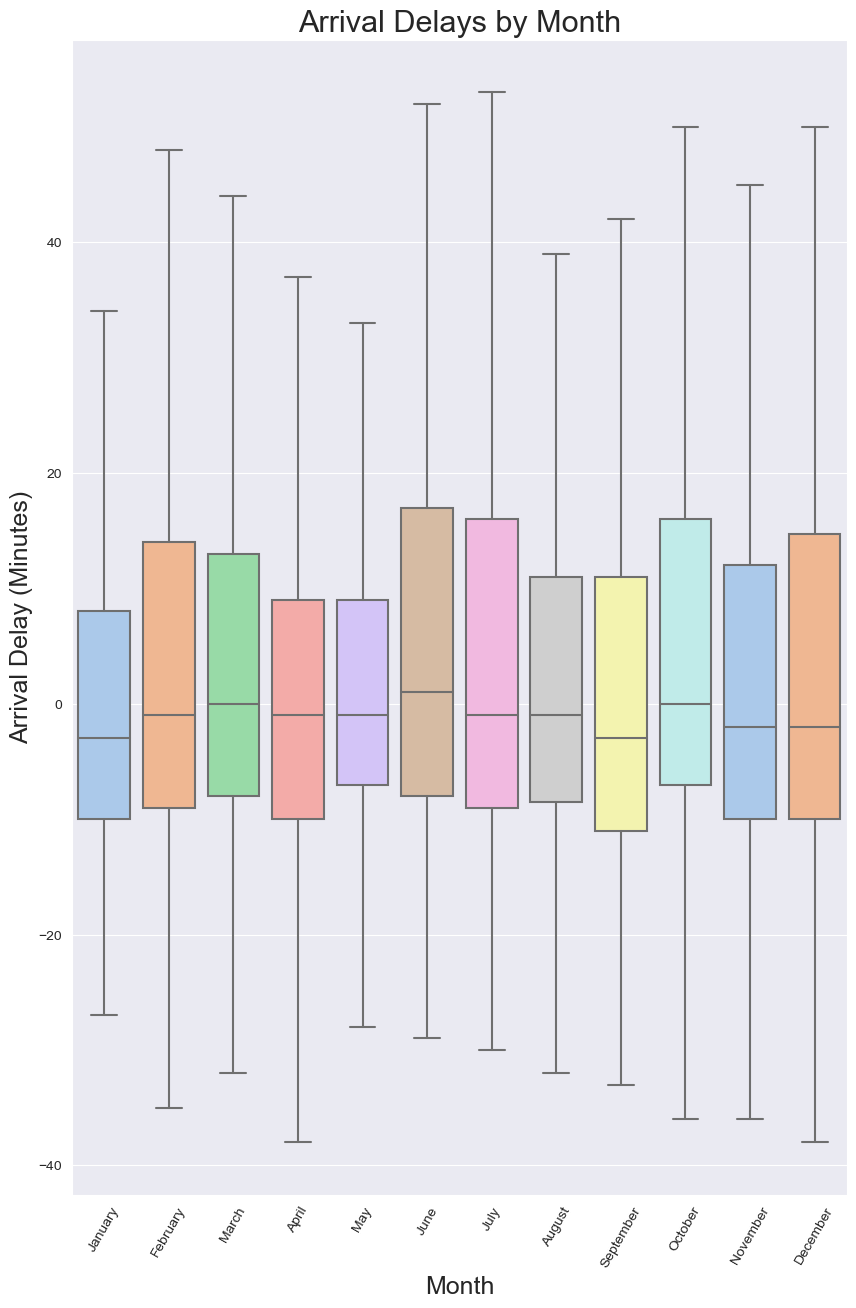

Month
1      2.546479
2      7.772080
3      9.383598
4      5.575130
5      5.186352
6     14.263923
7     12.415423
8      9.549398
9      7.483240
10    12.497340
11     6.518950
12    10.981283
Name: ArrDelay, dtype: float64


In [86]:
plt.clf()
plt.figure(figsize=(10,15)) # Adjust this depending on your dataset size
sns.set_style("darkgrid")
sns.boxplot(y='ArrDelay', x='Month', data=plane_df, showfliers = False, palette="pastel")
plt.title('Arrival Delays by Month',fontsize=22)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Arrival Delay (Minutes)',fontsize=18)
labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December'] 
plt.xticks(range(len(labels)), labels, rotation=60)
plt.show()

print(plane_df.groupby("Month").mean()["ArrDelay"])

- June had the largest mean arrival delay, whilst January had the lowest mean arrival delay.

## Scheduled Departure Time VS Arrival Delay

<AxesSubplot:>

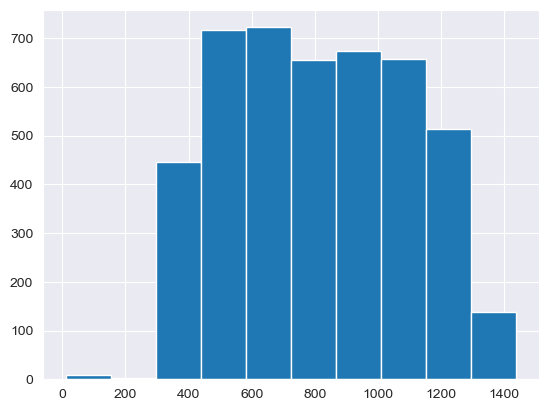

In [87]:
plane_df["CRSDepTimeMins_after_0000"].hist()

<Figure size 640x480 with 0 Axes>

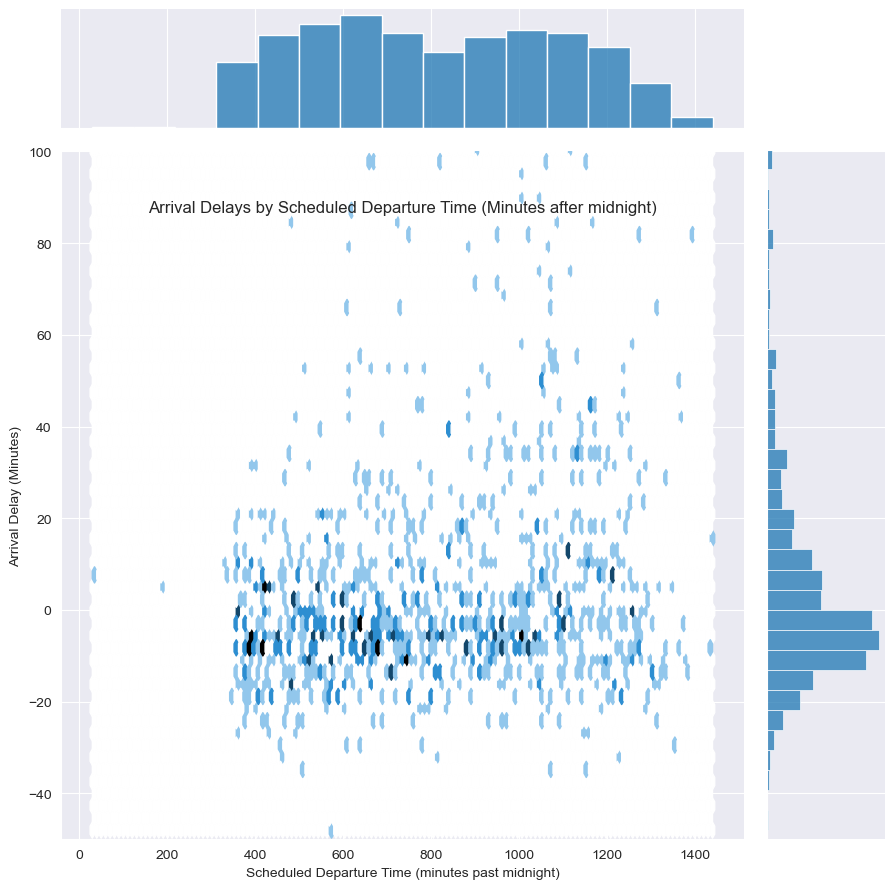

In [88]:
plt.clf()

fig = sns.jointplot(x="CRSDepTimeMins_after_0000", y='ArrDelay', data=plane_df.sample(1000), kind='hex', gridsize=140, height=9)

plt.ylim(-50,100)
plt.ylabel("Arrival Delay (Minutes)")
plt.title('Arrival Delays by Scheduled Departure Time (Minutes after midnight)', y=0.9)
plt.xlabel('Scheduled Departure Time (minutes past midnight)')

plt.show()

- Fairly Uniform distribution of arrival delays when placed against departure time, with a gradual taper off as it approaches midnight.

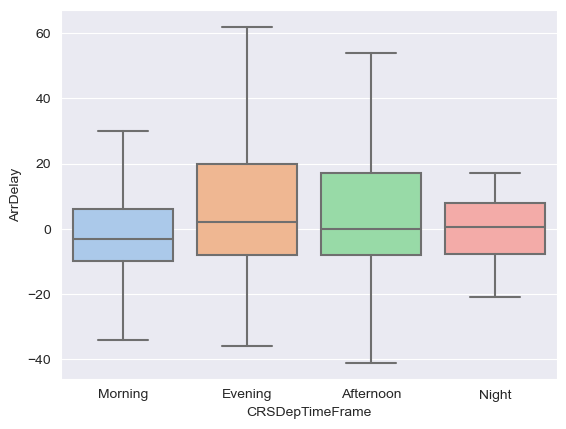

In [89]:
sns.boxplot(data=plane_df, x= "CRSDepTimeFrame", y="ArrDelay", showfliers= False, palette = "pastel")
plt.show()



- On average, flights departing in the morning and at night had the least arrival delay.

## Departure Delay VS Arrival Delay
#### These will inadvertently be correlated very closely. In the next notebook, this feature will only be used in the real-time prediction model.
#### Very linear relationship, as expected


In [90]:
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepTime,CRSDepTimeMins_after_0000,CRSDepTimeFrame,CRSElapsedTime,CRSArrTime,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,DepDelay,ArrDelay,ArrDelayClass
0,CVG,CMH,116.0,1,19,6,Summer,10:30:00,630,Morning,48.0,1118,OH,4,2,6,18,2,2,5.0,2.0,Slightly delayed
1,ATL,SGF,563.0,7,30,7,Summer,20:35:00,1235,Evening,112.0,2127,EV,5,2,7,17,2,1,153.0,136.0,Excessively delayed
2,PBI,BDL,1133.0,1,31,7,Summer,12:00:00,720,Afternoon,170.0,1450,DL,3,3,6,12,2,1,0.0,-4.0,On-time
3,PIT,PHL,267.0,3,27,12,Winter,16:50:00,1010,Afternoon,70.0,1800,US,4,4,8,19,1,1,-4.0,-11.0,On-time
4,ORD,ANC,2846.0,7,23,7,Summer,19:20:00,1160,Evening,399.0,2259,AS,11,3,14,12,1,2,8.0,-2.0,On-time


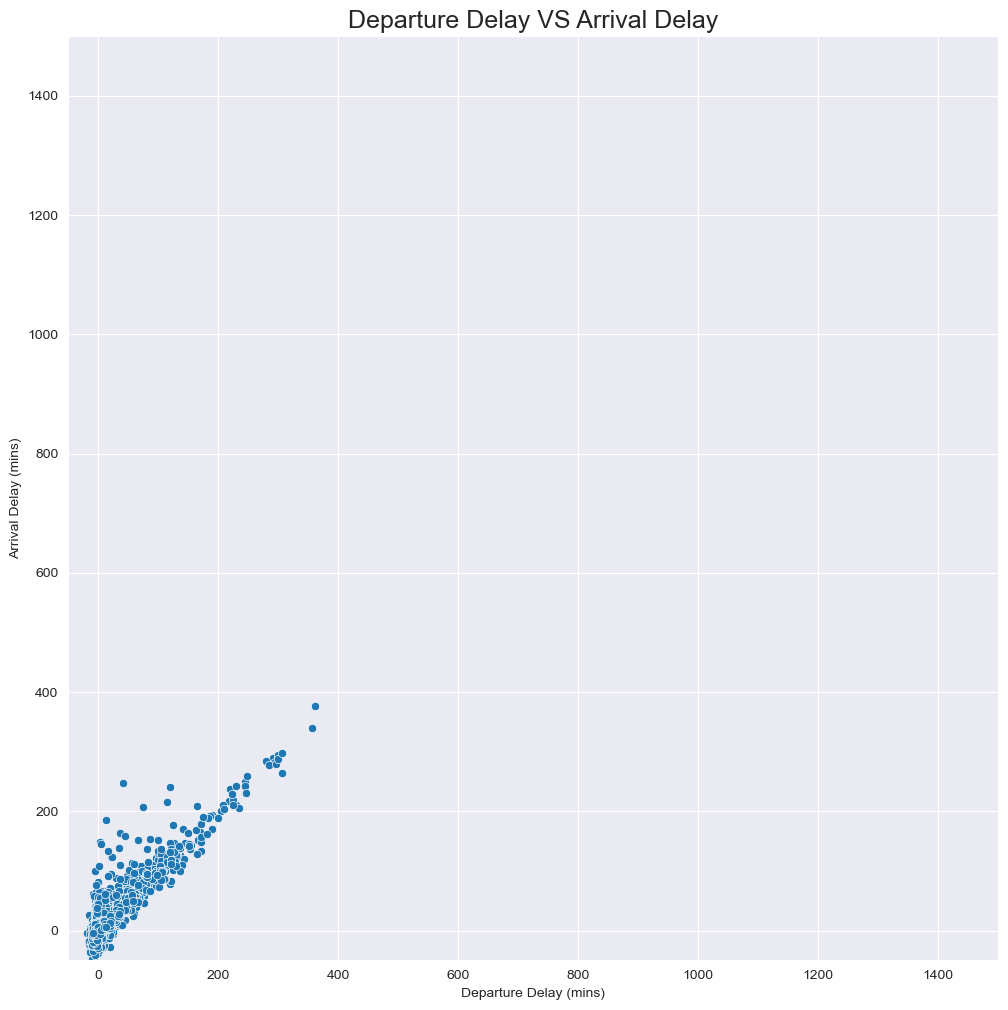

In [91]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=plane_df, x="DepDelay", y="ArrDelay")
plt.xlim(-50,1500)
plt.ylim(-50,1500)
plt.xlabel("Departure Delay (mins)")
plt.ylabel("Arrival Delay (mins)")
plt.title("Departure Delay VS Arrival Delay", fontsize=18)
plt.show()

- As expected, these 2 variables are very closely related

## Scheduled Journey Time VS Arrival Delay

<Figure size 640x480 with 0 Axes>

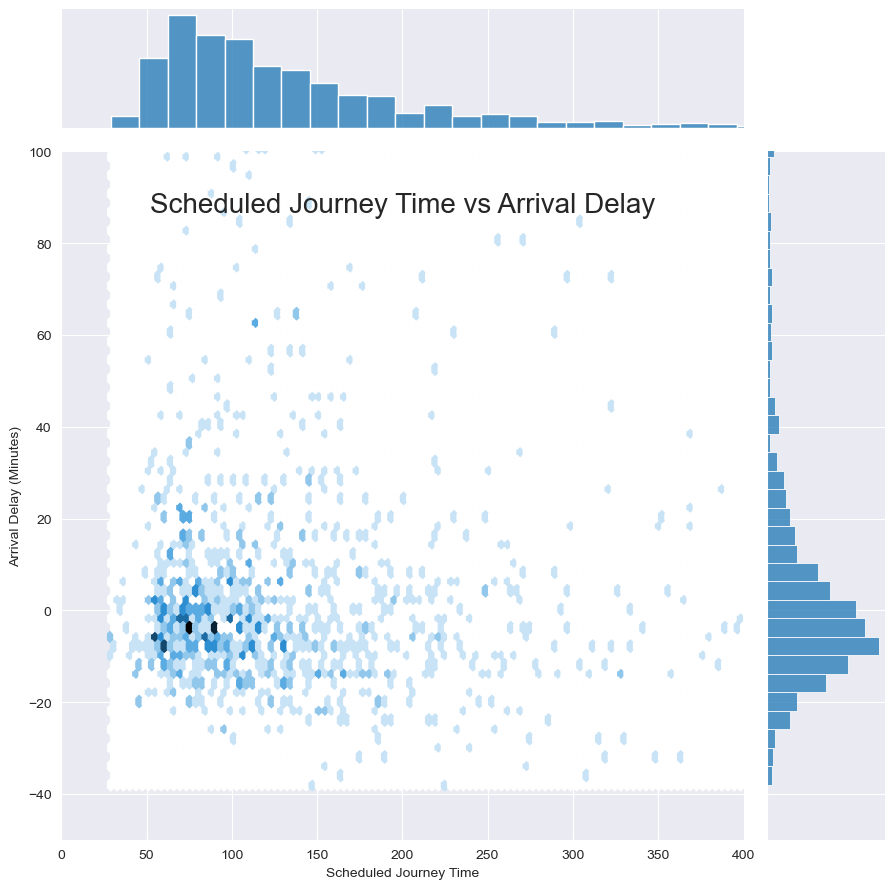

In [92]:
plt.clf()

fig = sns.jointplot(x="CRSElapsedTime", y='ArrDelay', data=plane_df.sample(1000), kind='hex', gridsize=140, height=9)

plt.ylim(-50,100)
plt.xlim(0,400)
plt.ylabel("Arrival Delay (Minutes)")
plt.title('Scheduled Journey Time vs Arrival Delay', y=0.9, fontsize=20)
plt.xlabel('Scheduled Journey Time')
plt.xticks()

plt.show()

- Shorter flights were much more likely to experience longer delay times. This is possibly due to the fact that pilots have less time to "catch up" once theyve taken off, in comparison to longer haul flights.

## How does the number of runways at airports influence Arrival Delay?

<Figure size 640x480 with 0 Axes>

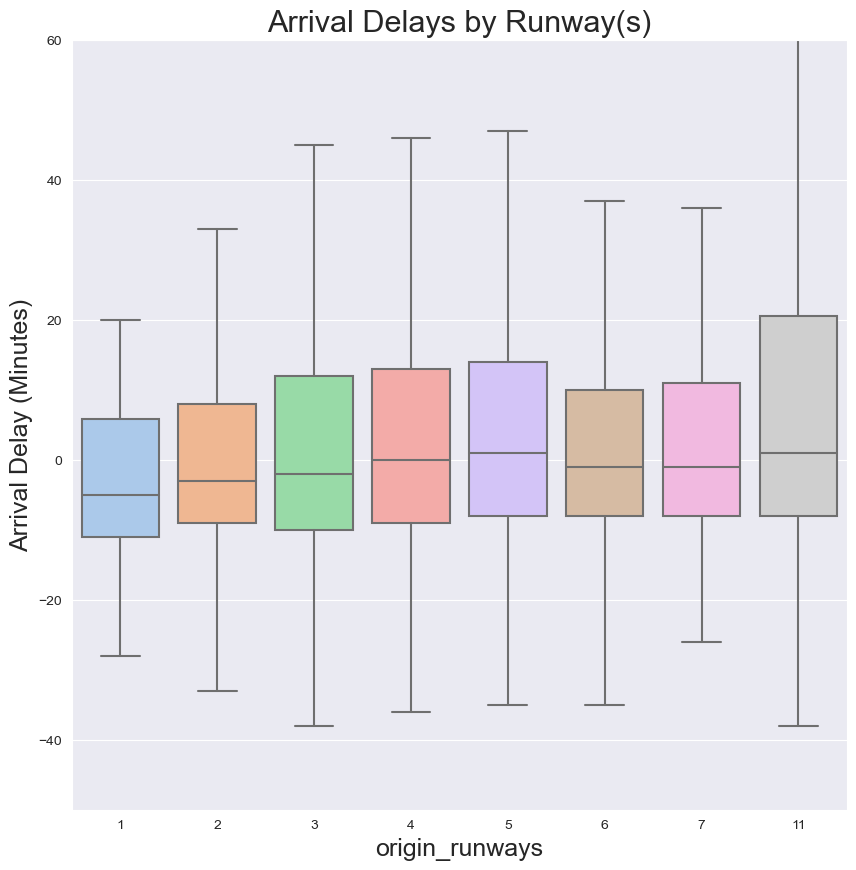

Average Delay (mins) by number of runways:  origin_runways
1      2.936170
2      4.962500
3      9.001779
4      8.117952
5     11.262956
6      6.408602
7     10.326633
11    16.706093
Name: ArrDelay, dtype: float64


<Figure size 640x480 with 0 Axes>

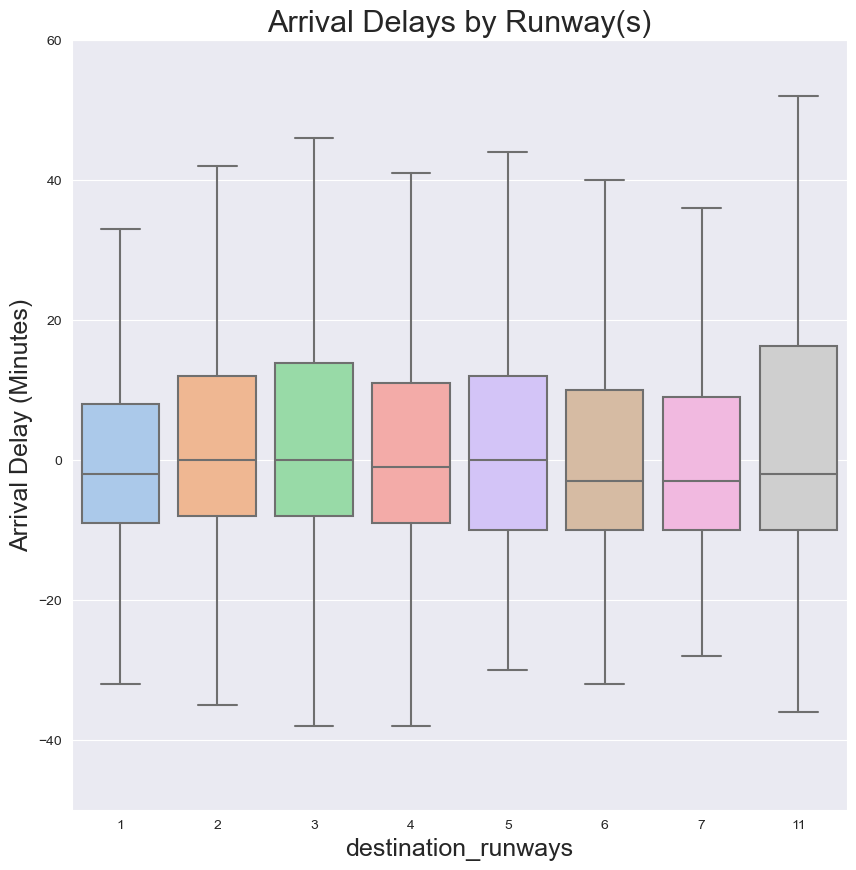

Average Delay (mins) by number of runways:  destination_runways
1      5.969697
2      7.235094
3     11.068696
4      7.333333
5      8.785219
6      5.597668
7      7.855346
11    18.740741
Name: ArrDelay, dtype: float64


<Figure size 640x480 with 0 Axes>

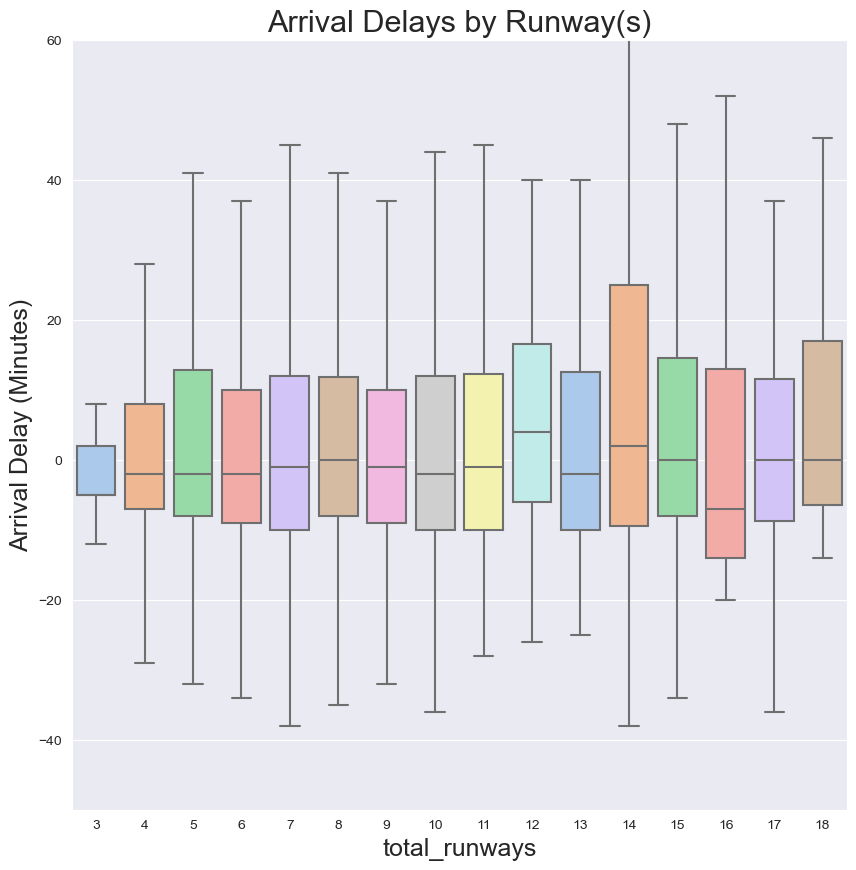

Average Delay (mins) by number of runways:  total_runways
3     -2.555556
4      5.876923
5      7.282443
6      7.258595
7      6.536278
8      9.351893
9      6.818499
10     9.461333
11     7.676829
12    15.363636
13     8.210526
14    24.464481
15    15.622642
16    15.520000
17     5.205882
18    18.066667
Name: ArrDelay, dtype: float64


In [93]:
plane_df.head()

runways = ["origin_runways","destination_runways", "total_runways"]

for runway in runways:
    plt.clf()
    plt.figure(figsize=(10,10)) 
    sns.set_style("darkgrid")
    sns.boxplot(y='ArrDelay', x=runway, data=plane_df,showfliers = False,  palette="pastel")
    plt.title('Arrival Delays by Runway(s)',fontsize=22)
    plt.xlabel(runway, fontsize=18)
    plt.ylabel('Arrival Delay (Minutes)',fontsize=18)
    plt.ylim(-50,60)
    plt.show()
    print("Average Delay (mins) by number of runways: ",plane_df.groupby(runway).mean()["ArrDelay"])
    

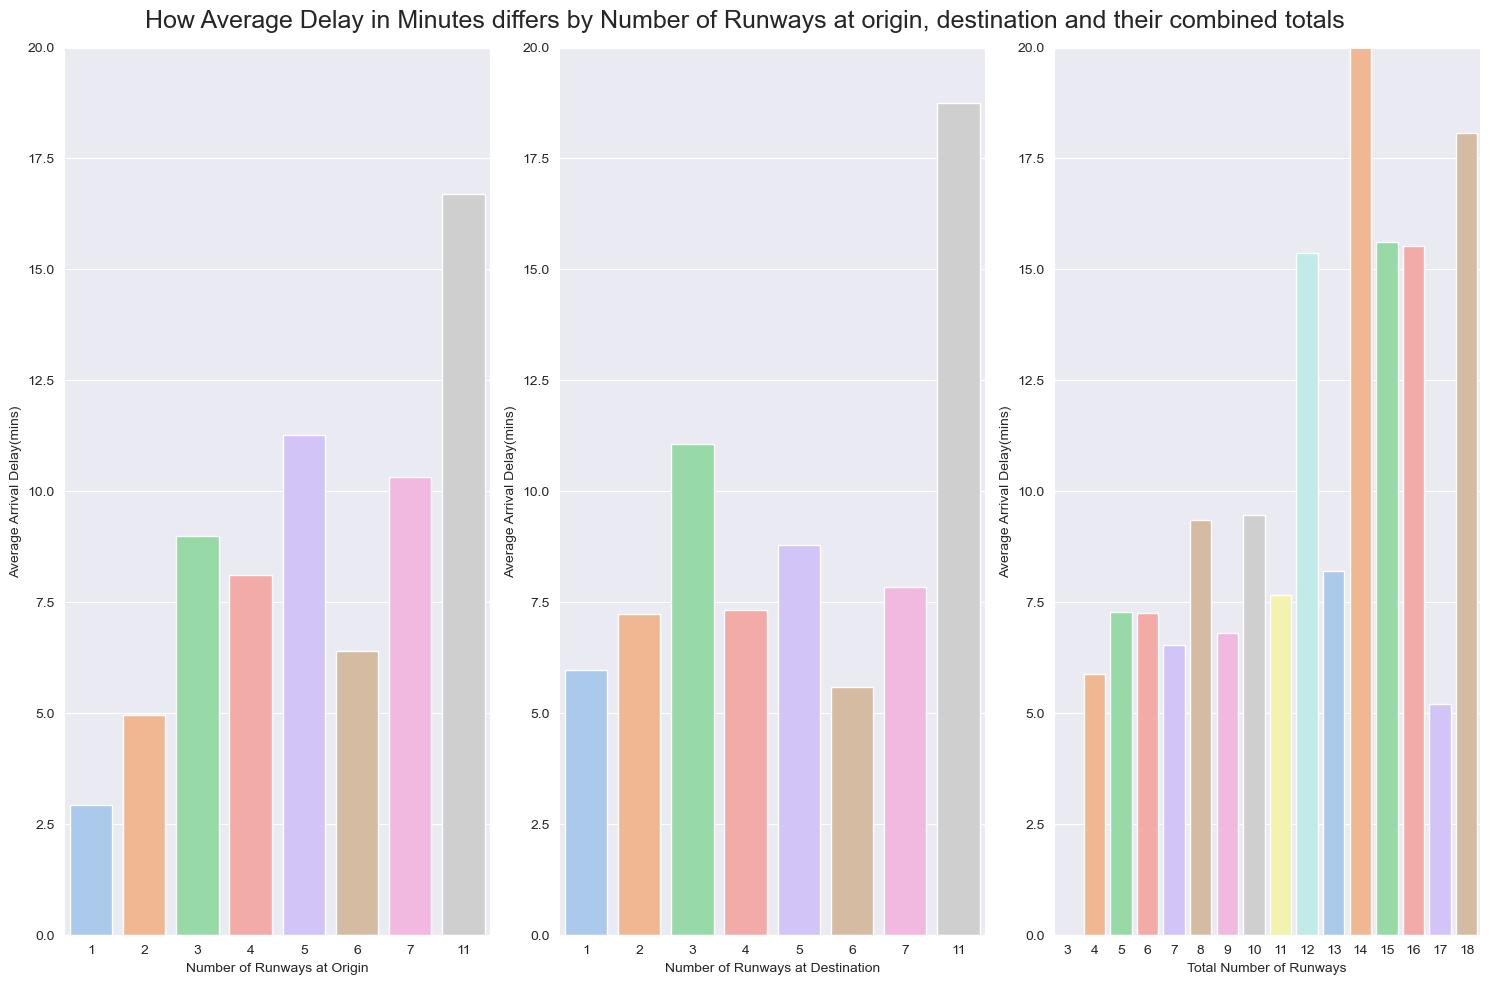

In [94]:
runways = ["origin_runways","destination_runways", "total_runways"]
runways_dict={}

for runway in runways:
    runways_dict[runway] = pd.DataFrame(plane_df.groupby(runway).mean()["ArrDelay"])
    

df_origin_runways = runways_dict["origin_runways"]
df_destination_runways = runways_dict["destination_runways"]
df_total_runways = runways_dict["total_runways"]

df_origin_runways.reset_index(inplace=True)
df_destination_runways.reset_index(inplace=True)
df_total_runways.reset_index(inplace=True)


#visualisation
fig, axs = plt.subplots(1, 3, figsize=(15,10))  
fig.suptitle('How Average Delay in Minutes differs by Number of Runways at origin, destination and their combined totals', fontsize=18)

sns.barplot(data=df_origin_runways, x="origin_runways", y="ArrDelay", ax=axs[0], palette="pastel")
sns.barplot(data=df_destination_runways, x="destination_runways", y="ArrDelay", ax=axs[1],palette="pastel")
sns.barplot(data=df_total_runways, x="total_runways", y="ArrDelay", ax=axs[2],palette="pastel")


axs[0].set_ylim([0,20])
axs[0].set_xlabel("Number of Runways at Origin")
axs[0].set_ylabel("Average Arrival Delay(mins)")

axs[1].set_ylim([0,20])
axs[1].set_xlabel("Number of Runways at Destination")
axs[1].set_ylabel("Average Arrival Delay(mins)")

axs[2].set_ylim([0,20])
axs[2].set_xlabel("Total Number of Runways")
axs[2].set_ylabel("Average Arrival Delay(mins)")


plt.tight_layout()
plt.show()


- By looking at the above visualisations, it is clear that the total number of runwways at the aiport of origin and arrival are directly linked to arrival delays.

## Delays By airline

<Figure size 640x480 with 0 Axes>

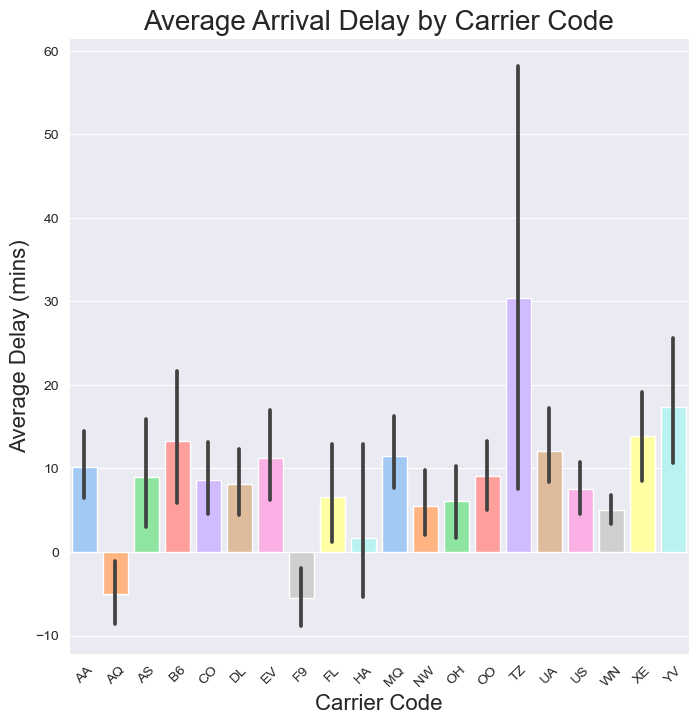

In [95]:
plt.clf()
sns.set_style("darkgrid")
plt.figure(figsize=(8, 8))
sns.barplot(data = plane_df, x="UniqueCarrier", y="ArrDelay", saturation=1, palette="pastel")
plt.title("Average Arrival Delay by Carrier Code", fontsize=20)
plt.xlabel("Carrier Code", fontsize=16)
plt.ylabel("Average Delay (mins)", fontsize=16)
plt.xticks(rotation=45)
plt.show()

- Some airlines may have worse operational practices and therefore be less efficient. (Scheduling, baggage handling, turnaround times)
- Some airlines may have older aircraft, more prone to longer grounding periods to deal with mechanical issues, thus putting additional pressure on other planes in the fleet.
- Some carriers may fly a large proportion of their flights between airports where delays are more common (More an issue with the airport rather than the carrier)


## Which Weekday & Month had the most flights?

Text(0.5, 1.0, 'Number of Flights per Weekday in 2006')

<Figure size 640x480 with 0 Axes>

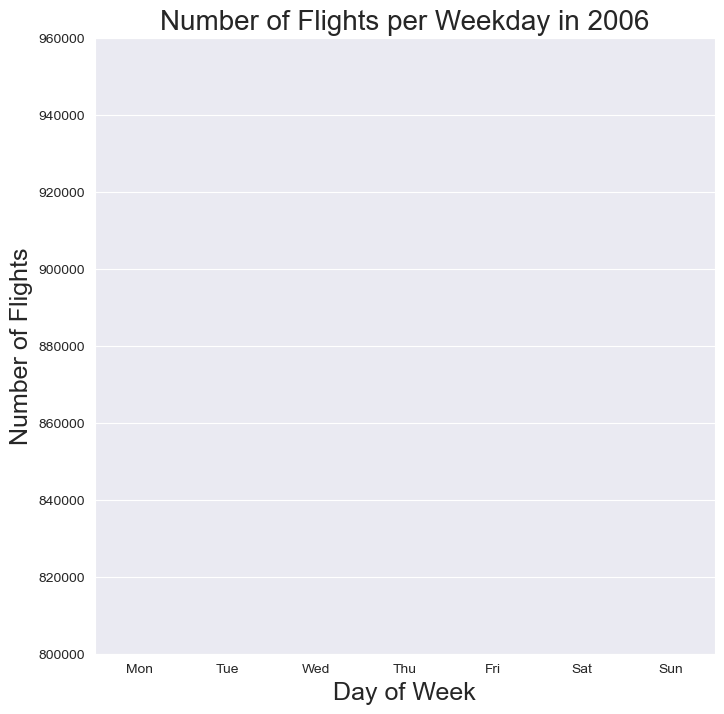

In [96]:
flights_by_weekday = plane_df.groupby("DayOfWeek").size()
flights_by_weekday
flights_by_weekday_df = flights_by_weekday.reset_index()
flights_by_weekday_df.columns = ['Day_of_Week', 'Number_Flights']
flights_by_weekday_df

plt.clf()
sns.set_style("darkgrid")
plt.figure(figsize=(8, 8))
sns.barplot(data=flights_by_weekday_df, x="Day_of_Week", y="Number_Flights", palette="pastel")
plt.ylim([800000,960000])
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(range(len(labels)), labels)
plt.xlabel("Day of Week", fontsize=18)
plt.ylabel("Number of Flights", fontsize=18)
plt.title("Number of Flights per Weekday in 2006", fontsize=20)

- This can partly explain why Friday had the longest average delays and Saturday the shortest. They are the most popular and least popular travel days respectively.

Text(0.5, 1.0, 'Number of Flights per Month in 2006')

<Figure size 640x480 with 0 Axes>

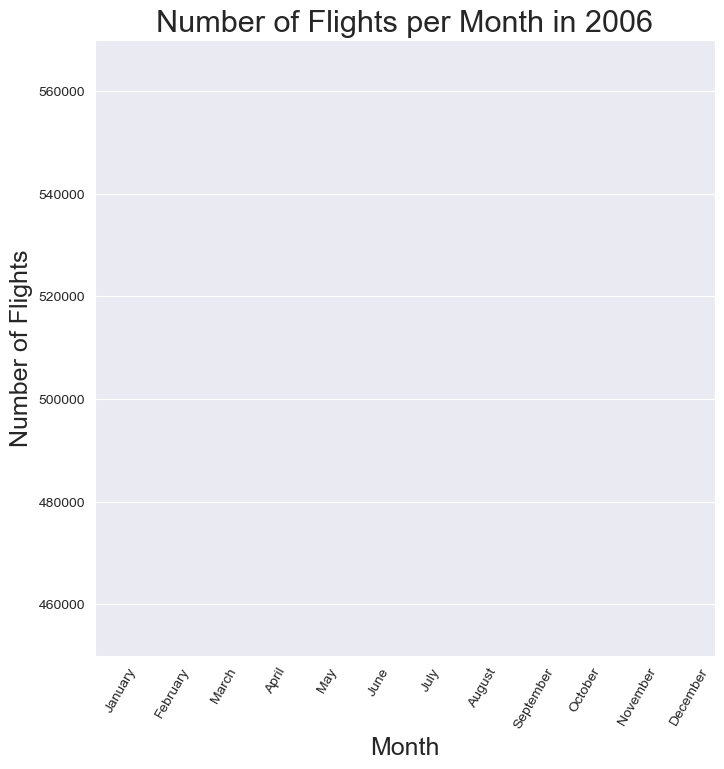

In [97]:
flights_by_month = plane_df.groupby("Month").size()
flights_by_month
flights_by_month_df = flights_by_month.reset_index()
flights_by_month_df.columns = ['Month', 'Number_Flights']
flights_by_month_df

plt.clf()
sns.set_style("darkgrid")
plt.figure(figsize=(8, 8))
sns.barplot(data=flights_by_month_df, x="Month", y="Number_Flights", palette='pastel')
plt.ylim([450000, 570000])
labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December'] 
plt.xticks(range(len(labels)), labels, rotation=60)
plt.xlabel("Month", fontsize=18)
plt.ylabel("Number of Flights", fontsize=18)
plt.title("Number of Flights per Month in 2006",fontsize=22)

- February had the least flights, whilst August had the most flights
- The popularity of a flying weekday/month can explain the average delay relatively well.

## What were the busiest and calmest days of the year?

In [98]:
plane_df["Date"] = pd.to_datetime('2006-' + plane_df["Month"].astype(str) + '-' + plane_df["DayofMonth"].astype(str), format='%Y-%m-%d')
daily_flights = plane_df.groupby("Date").size()
print(daily_flights.nlargest(10))
print(daily_flights.nsmallest(10))

Date
2006-06-20    25
2006-01-20    24
2006-04-10    23
2006-06-28    21
2006-09-17    21
2006-10-19    21
2006-02-21    20
2006-02-22    20
2006-04-27    20
2006-07-14    20
dtype: int64
Date
2006-12-24    3
2006-01-17    4
2006-02-18    4
2006-09-27    4
2006-10-14    5
2006-11-10    5
2006-11-14    5
2006-01-26    6
2006-02-10    6
2006-03-15    6
dtype: int64


- The top 3 most congested days were all in august.
- From the top 10 least popular days of the year to fly, 8 were in either January or February.

## Time Series Plot

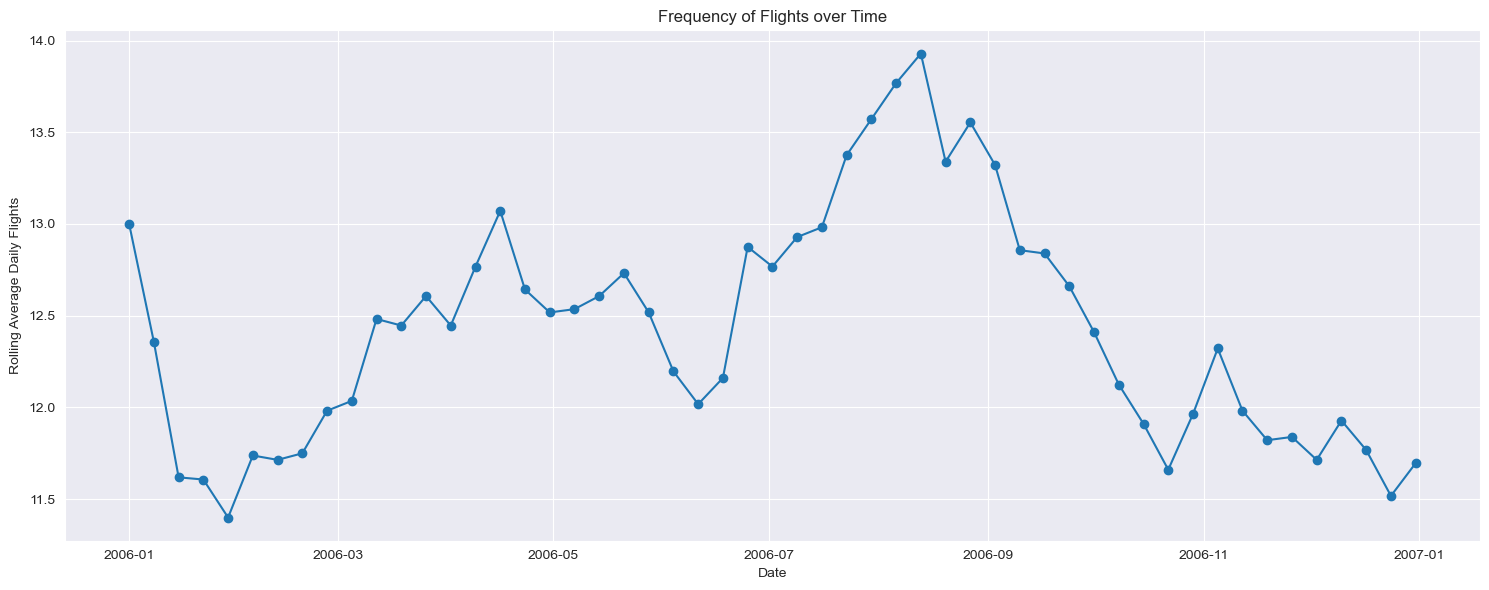

In [99]:
weekly_flights = daily_flights.resample('w').mean()

#Rolling Mean over 2 month period
smoothed_flights = weekly_flights.rolling(window=8, min_periods=0).mean()

plt.figure(figsize=(15, 6))
plt.plot(smoothed_flights, marker='o')


plt.title('Frequency of Flights over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Average Daily Flights')


plt.tight_layout()
plt.show()


- The 2 month rolling average time series above shows how the number of flights steadily increased over the course of the year up until late august, before starting to decline again.

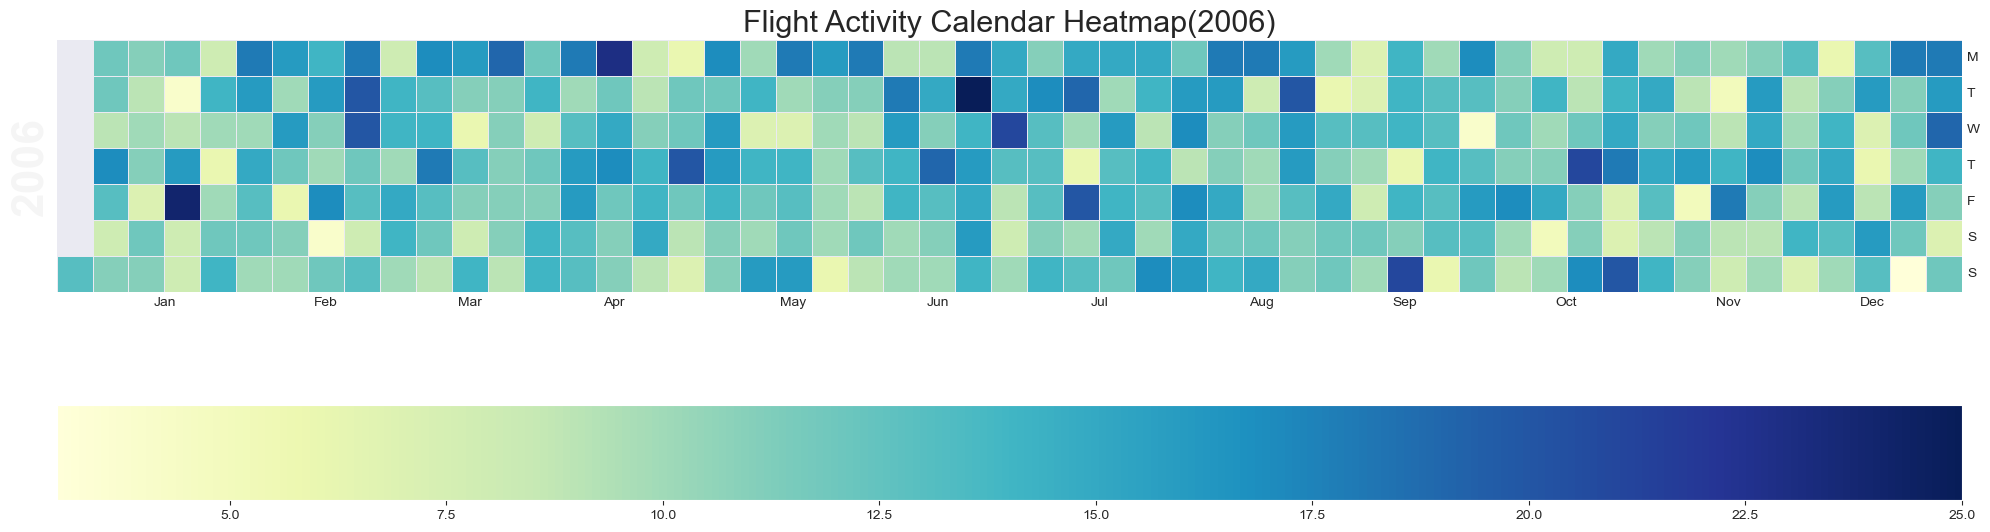

In [100]:
import calmap

fig, ax = calmap.calendarplot(daily_flights, monthticks=1, daylabels='MTWTFSS',
                    dayticks=1, cmap='YlGnBu', linewidth=0.5,
                    fig_kws=dict(figsize=(20, 8)))
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist(), orientation='horizontal')
plt.title('Flight Activity Calendar Heatmap(2006)', fontsize=22)

plt.show()

- The calendar mapping above allows us to see any outliers in our data, as well as trend across the year.
- We can see that there were certain days less busy than normal, such as a Sunday in February, and days towards the end of the year, probably due to it being a holiday season.

In [101]:
#Code to create csv files of data in current notebook
#plane_df.columns
#plane_df.to_csv("5000flights.csv")